In [9]:
import networkx as nx
import numpy as np
import pickle
from parser import *
import os
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [16]:
data_dir = "../data/L_16/"
W_list = [0.001] + list(range(1,9))
num_dis = 43
i_max = 21

In [17]:
def load_diagnostics(fname):
    E_dict = {}
    with open(fname, 'r') as fp:
        data = fp.readlines()
        energies = np.array(data[-6].split()[2:]).astype(float)
        e_diffs = energies[1:] - energies[:-1]
        spacings = [min(e_diffs[i:i+2])/max(e_diffs[i:i+2]) for i in range(len(e_diffs)-2)]
        ll = data[-1].split()
        E = float(ll[2])
        var = float(ll[3])
        EE = float(ll[4])
        r = np.mean(spacings)
        
    return E, var, EE, r

In [18]:
W_info = {}
for W in W_list:
        i_list   = []
        for i in range(i_max):
            E_list, var_list, EE_list, r_list = [], [], [], []
            for dis in range(num_dis):
                d = "{}W_{}/".format(data_dir, W)
                fname = "{}epsilon_{:02}_{:02}.txt".format(d, i, dis)
                E, var, EE, r = load_diagnostics(fname)
                E_list.append(E)
                var_list.append(var)
                EE_list.append(EE)
                r_list.append(r)
            E, var, EE, r = np.mean(E_list), np.mean(var_list), np.mean(EE_list), np.mean(r_list) 
            i_list.append([E, var, EE, i/100, r])
        W_info[W] = i_list
    
points = []    
for W in W_list:
    i_list = W_info[W]
    E_list, var_list, EE_list, ep_list, r_list = list(zip(*i_list))
    E_list = (np.array(E_list) - min(E_list))/(max(E_list) - min(E_list))
    points += [(W, E, var, EE, i, r) for E, var, EE, i, r in zip(E_list, var_list, EE_list, ep_list, r_list)]

<IPython.core.display.Javascript object>


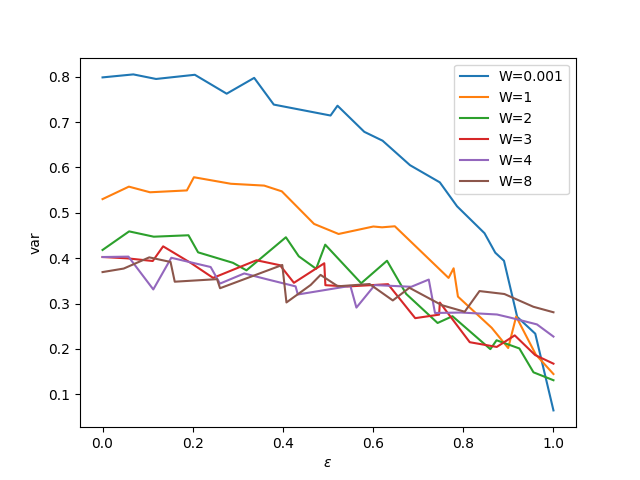

In [35]:
%matplotlib notebook
N = 1
delta_N = []
for W in [0.001, 1, 2, 3,4, 8]:
    i_list = W_info[W]
    E_list, var_list, EE_list, ep_list, r_list = list(zip(*i_list))
    E_list, var_list, EE_list, ep_list, r_list = list(zip(*([(E, var, EE, ep, r) for E,var,EE, ep, r in sorted(zip(E_list,var_list, EE_list, ep_list, r_list))])))


    epsilon_list = (np.array(E_list) - min(E_list))/(max(E_list)-min(E_list))

    E_list   = np.convolve(  E_list, np.ones((N,))/N, mode='valid')
    var_list = np.convolve(var_list,np.ones((N,))/N, mode='valid')
    r_list   = np.convolve( EE_list, np.ones((N,))/N, mode='valid')
    plt.plot(epsilon_list, var_list, label="W={}".format(W))
plt.legend(loc='best')
plt.xlabel(r"$\varepsilon$")
plt.ylabel("var")
plt.show()

<IPython.core.display.Javascript object>


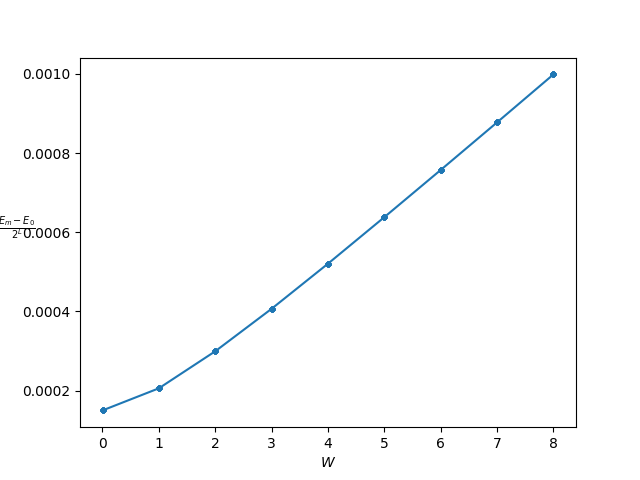

In [34]:
%matplotlib notebook
N = 1
E_ground = []
delta_N = []
for W in W_list:
    i_list = W_info[W]
    E_list, var_list, EE_list, ep_list, r_list = list(zip(*i_list))
    E_list, var_list, EE_list, ep_list, r_list = list(zip(*([(E, var, EE, ep, r) for E,var,EE, ep, r in sorted(zip(E_list,var_list, EE_list, ep_list, r_list))])))
    E_ground.append(E_list[0])
    dE_dN = (E_list[-1] - E_list[0])/(2**16)
    #varmax = max(var_list)
    delta_N.append(dE_dN)
plt.plot(W_list, delta_N, '.-')
plt.xlabel(r"$W$")
plt.ylabel(r"$\frac{E_m - E_0}{2^L}$", rotation=0)
plt.show()

<IPython.core.display.Javascript object>


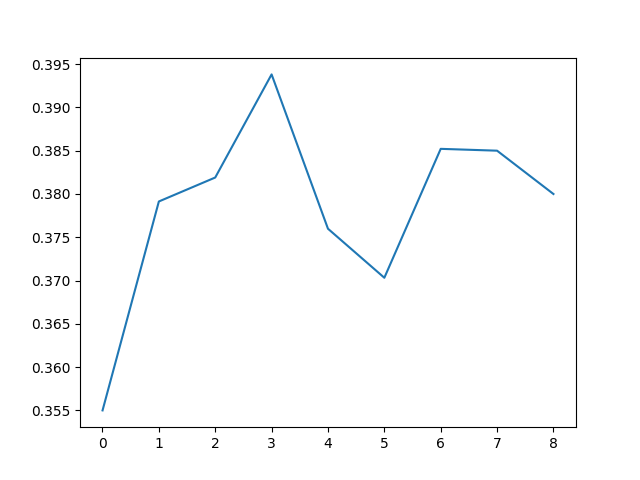

In [20]:
%matplotlib notebook
var_avg = []
EE_avg = []
for W in W_list:
    i_list = W_info[W]
    E_list, var_list, EE_list, ep_list, r_list = list(zip(*i_list))
    var_avg.append(np.mean(var_list))
    EE_avg.append(np.mean(r_list))
plt.plot(W_list, EE_avg)
plt.show()


<IPython.core.display.Javascript object>


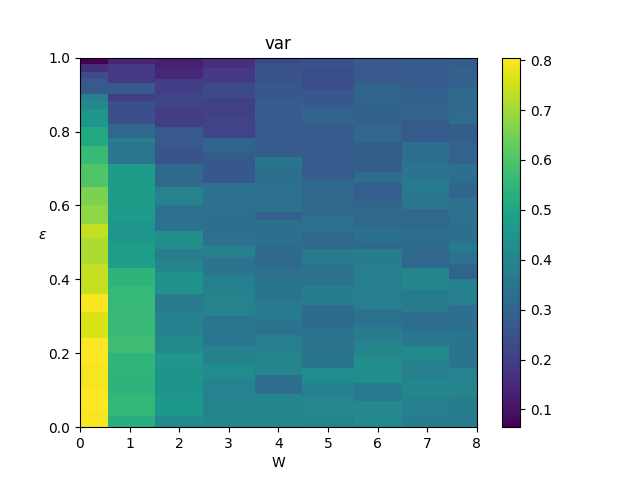

In [22]:
%matplotlib notebook
N = 1
W_list, E_list, var_list, EE_list, ep_list, r_list = list(zip(*points))

E_list   = np.convolve(  E_list, np.ones((N,))/N, mode='valid')
var_list = np.convolve(var_list,np.ones((N,))/N, mode='valid')
EE_list   = np.convolve( EE_list, np.ones((N,))/N, mode='valid')
r_list   = np.convolve( r_list, np.ones((N,))/N, mode='valid')


grid_x, grid_y = np.mgrid[0:8:100j, 0:1:100j]
zz = griddata(list(zip(W_list, E_list)), var_list, (grid_x, grid_y), 'nearest')
plt.imshow(zz.T, extent=(0,8,0,1), origin='lower', aspect='auto')
plt.ylabel(r"$\varepsilon$", rotation=0)
plt.xlabel("W")
plt.title("var")
plt.colorbar()
plt.show()